# Analisis de acciones Bancolombia

# 2020-01-01 - 2020-01-01

In [1]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

## 0. Introducción e importación de datos

La elección de la base de datos que abarca el periodo 2000-01-01 a 2020-01-01 para analizar las acciones de Bancolombia se justifica por la exclusión del impacto de la pandemia mundial, permitiendo un enfoque claro en factores y tendencias previas a este suceso. La extensión temporal facilita la evaluación del comportamiento de las acciones, buscando determinar si siguen una caminata aleatoria, lo que es esencial para evaluar la eficacia de estrategias de inversión basadas en análisis histórico. Además, la serie temporal presenta irregularidades en la espaciación de los datos, lo que agrega complejidad al análisis y requiere adaptación en las técnicas utilizadas para tener en cuenta la variabilidad en la frecuencia de observaciones.

In [2]:
ticker_name = 'BC'

data = yf.download(ticker_name, start='2000-01-01', end='2020-01-01')
print(data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed
(5031, 6)


Open      High      Low    Close  Adj Close  Volume
Date                                                              
2000-01-03  22.0000  22.09375  21.6875  21.9375  15.422194  286700
2000-01-04  21.9375  22.12500  20.8750  20.9375  14.719192  338700
2000-01-05  20.6875  21.62500  20.6875  21.0625  14.807069  214000
2000-01-06  21.1250  21.31250  20.8750  21.2500  14.938883  232700
2000-01-07  21.2500  21.62500  20.9375  21.3750  15.026753  207800

In [3]:
data.shape

(5031, 6)

In [4]:
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index).date
df["Close"] = data["Close"].values
df.head()

Date    Close
0  2000-01-03  21.9375
1  2000-01-04  20.9375
2  2000-01-05  21.0625
3  2000-01-06  21.2500
4  2000-01-07  21.3750

In [5]:

fig = go.Figure()
# Suponiendo que ya tienes el DataFrame df

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["Close"],
    name="NeuralProphet Forescasting",
    line=dict(color='blue', width=2)
))
fig.update_xaxes(type='category')  # Para que las fechas se muestren correctamente

# Centrar el título
fig.update_layout(title_text='Precio de acciones Bancolombia', title_x=0.5)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    )
)

# Análisis descriptivo de una serie de tiempo

## 1. Estabilizar varianza.
En esta sección se buscará una herramienta para estabilizar la varianza, siempre y cuando pareciera que no se encuentre estabilizada.

#### Familia de transformaciones Box-Cox:

En ocasiones la serie presenta varianza marginal no constante a lo largo del tiempo, lo cual hace necesario tener en cuenta tal característica. En este caso, se siguiere hacer una transformación de potencia para estabilizar la varianza. Esta familia de transformaciones se llaman transformaciones Box-Cox.

$$
    f_{\lambda}(u_{t})= \begin{cases}
        \lambda^{-1}(u^{\lambda}_{t}-1), &  \text{si  $u_{t} \geq 0$, para $\lambda>0$,}\\
        \ln(u_{t}), &\text{ si $u_{t}>0$, para $\lambda=0$}.
    \end{cases}
$$

note que la familia de funciones dependen del $\lambda$ escogido, pero como se escoge $\lambda$?. La respuesta es usando librerías de $R$ o Python.

**Nota**: Si el lambda calculado es muy cercano a 1, se recomienda no hacer Box-cox

In [6]:
from scipy.stats import boxcox

In [7]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
import numpy as np
from scipy.stats import boxcox
import warnings

warnings.filterwarnings("ignore")

# Importar datos
ticker_name = 'BC'
data = yf.download(ticker_name, start='2000-01-01', end='2020-01-01')
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index).date
df["Close"] = data["Close"].values

# Análisis Box-Cox
df['BoxCox_Close'], lambda_value = boxcox(df['Close'])  # Agregar 1 para evitar problemas con valores no positivos

fig = go.Figure()
# Suponiendo que ya tienes el DataFrame df

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["Close"],
    name="Original",
    line=dict(color='blue', width=2)
))
fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["BoxCox_Close"],
    name="Box-Cox",
    line=dict(color='green', width=2)
))
fig.update_xaxes(type='category')  # Para que las fechas se muestren correctamente

# Centrar el título
fig.update_layout(title=dict(
        text = 'Precio de acciones Bancolombia <br>' + f'Box-Cox (λ={round(lambda_value, 3)})',
        font=dict(size=20)  # Ajustar el tamaño del título
    ) , title_x=0.75)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    ),
    margin=dict(l=0, r=20, t=100, b=50)
)

fig.update_layout(
    xaxis=dict(title=dict(font=dict(size=20))),
    yaxis=dict(title=dict(font=dict(size=20))),
    legend=dict(font=dict(size=17))
)



[*********************100%***********************]  1 of 1 completed


## 2. Análisis de la tendencia y eliminación:

Los procedimientos que permiten estimar y extraer los componentes de tendencia y/o estacionalidad se conoce como **suavizamiento**.

### 2.1. Promedio móvil :

El promedio móvil es un método útil para descubrir ciertos rasgos en una serie de tiempo, como **tendencias a largo plazo y componentes estacionales**. En particular, si $x_t$ representa las observaciones, entonces una forma de predecir o estimar la tendencia de la serie es:

$$m_t=\sum_{j=-k}^{k}a_jx_{t-j},$$ 

donde si $a_j=a_{-j}\geq 0$ y $\sum_{j=-k}^{k}a_j=1$ se conoce como el promedio móvil simétrico de los datos.


In [8]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import yfinance as yf
from scipy import stats

warnings.filterwarnings("ignore")

# Importar datos
ticker_name = 'BC'
data = yf.download(ticker_name, start='2000-01-01', end='2020-01-01')
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index).date
df["Close"] = data["Close"].values

# Análisis Box-Cox
df['BoxCox_Close'], lambda_value = boxcox(df['Close'])  # Agregar 1 para evitar problemas con valores no positivos

# Agregar columnas de promedios móviles (SMA) con ventanas de 10, 50, 100, 200, 500 y 1000 días
df['SMA_10'] = df['BoxCox_Close'].rolling(window=10).mean()
df['SMA_50'] = df['BoxCox_Close'].rolling(window=50).mean()
df['SMA_100'] = df['BoxCox_Close'].rolling(window=100).mean()
df['SMA_200'] = df['BoxCox_Close'].rolling(window=200).mean()
df['SMA_500'] = df['BoxCox_Close'].rolling(window=500).mean()
df['SMA_1000'] = df['BoxCox_Close'].rolling(window=1000).mean()

# Crear gráfico
fig = go.Figure()

# Suponiendo que ya tienes el DataFrame df

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["BoxCox_Close"],
    name="Box-Cox",
    line=dict(color='green', width=2)
))

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["SMA_10"],
    name="SMA (10 days)",
    line=dict(color='orange', width=2)
))

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["SMA_50"],
    name="SMA (50 days)",
    line=dict(color='red', width=2)
))

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["SMA_100"],
    name="SMA (100 days)",
    line=dict(color='purple', width=2)
))

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["SMA_200"],
    name="SMA (200 days)",
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["SMA_500"],
    name="SMA (500 days)",
    line=dict(color='pink', width=2)
))

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["SMA_1000"],
    name="SMA (1000 days)",
    line=dict(color='cyan', width=2)
))

fig.update_xaxes(type='category')  # Para que las fechas se muestren correctamente

# Centrar el título
fig.update_layout(title_text='Precio de acciones Bancolombia con SMAs', title_x=0.5)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    )
)





[*********************100%***********************]  1 of 1 completed


## 2.2 Suavisamiento Kernel

El suavizamiento kernel es un suavizador de promedio móvil que utiliza una función de ponderación, o kernel, para promediar las observaciones.Veamos ahora como queda el promedio móvil:

$$m_t= \sum_{i=1}^n \omega_i(t)x_i$$
donde, 
$$w_i(t)=K(\frac{t-i}{b})/\sum_{j=1}^{n}K(\frac{t-j}{b})$$

son los pesos y $K(\cdot)$ es una función kernel.

In [9]:
from scipy.ndimage import gaussian_filter1d


df['Smoothed_BoxCox_1'] = gaussian_filter1d(df['BoxCox_Close'], sigma=1)
df['Smoothed_BoxCox_10'] = gaussian_filter1d(df['BoxCox_Close'], sigma=10)
df['Smoothed_BoxCox_100'] = gaussian_filter1d(df['BoxCox_Close'], sigma=100)
df['Smoothed_BoxCox_200'] = gaussian_filter1d(df['BoxCox_Close'], sigma=200)

# Crear gráfico
fig = go.Figure()

# Suponiendo que ya tienes el DataFrame df

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["BoxCox_Close"],
    name="Box-Cox",
    line=dict(color='green', width=2)
))

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["Smoothed_BoxCox_1"],
    name="Kernel (σ=1)",
    line=dict(color='orange', width=2)
))
fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["Smoothed_BoxCox_10"],
    name="Kernel (σ=10)",
    line=dict(color='red', width=2)
))
fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["Smoothed_BoxCox_100"],
    name="Kernel (σ=100)",
    line=dict(color='purple', width=2)
))
fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["Smoothed_BoxCox_200"],
    name="Kernel (σ=0)",
    line=dict(color='blue', width=2)
))


fig.update_xaxes(type='category')  # Para que las fechas se muestren correctamente

# Centrar el título
fig.update_layout(title_text='Precio de acciones Bancolombia con Suavisamiento Kernel', title_x=0.5)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    )
)



### 2.3 Loess o Lowess

Otro enfoque para suavizar un gráfico de tiempo es la regresión del vecino más cercano. La técnica se basa en la regresión de k vecinos más cercanos, en la que uno usa solo los datos $\{x_{t−k/2}, ..., x_t, ..., x_{t+k/2}\}$ para predecir $x_t$ mediante regresión, y luego establece $m_t = \hat{x}_t$. Primero, una cierta proporción de vecinos más cercanos a $x_t$ se incluyen en un esquema de ponderación; los valores más cercanos a $x_t$ en el tiempo obtienen más peso. Luego, se utiliza una regresión ponderada robusta para predecir $x_t$ y obtener los valores suavizados $m_t$. Cuanto mayor sea la fracción de vecinos más cercanos incluidos, más suave será el ajuste. 

In [10]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
from scipy.stats import boxcox
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df["BoxCox_Close"],
    name="Box-Cox",
    line=dict(color='green', width=2)
))

frac = 0.075  # Puedes seleccionar el valor de frac que desees
smoothed_values = lowess(df['BoxCox_Close'], df.index, frac=frac, it=0)

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=smoothed_values[:, 1],
    name=f"Smoothed (frac={frac})",
    line=dict(width=2)
))

trend_removed = df['BoxCox_Close'] - smoothed_values[:, 1]

fig.add_trace(go.Scatter(
    x=df["Date"],
    y=trend_removed,
    name="Trend Removed",
    line=dict(width=2)
))

# Configuración del diseño del gráfico
fig.update_xaxes(type='category')  # Para que las fechas se muestren correctamente
fig.update_layout(
    title_text=f'Eliminación de tendencia Lowess con frac = {frac}',
    title_x=0.5,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    ),
    xaxis_title="Date",
    yaxis_title="Values",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    )
)

### 2.4 Suavizamiento Splines

Una forma obvia de suavizar los datos sería ajustar una regresión polinomial en términos del tiempo. Por ejemplo, un polinomio cúbico tendría $x_t = m_t + w_t$ donde $m_t =\beta_0 + \beta_1t + \beta_2t^2 + \beta_3t^3$. Entonces podríamos ajustar $m_t$ mediante mínimos cuadrados ordinarios.

Una extensión de la regresión polinomial es dividir primero el tiempo $t = 1,. . . , n$, en k intervalos, $[t_0 = 1, t_1]$, $[t_1 + 1, t_2],\cdots,$ $[t_{k − 1} + 1, t_k = n]$; los valores $t_0$, $t_1$, …, $t_k$ se llaman nodos. Luego, en cada intervalo, se ajusta una regresión polinomial, normalmente de orden 3, y esto se llama splines cúbicos. Un método relacionado es suavizar splines, que minimiza el compromiso entre el ajuste y el grado de suavidad dado por

$$\sum_{t=1}^{n}[x_t-m_t]^2+\lambda\int(m_t'')^2 dt,$$

donde $m_t$ es un spline cúbico con nodos en cada tiempo t y el grado de suavidad es controlado por $\lambda>0.$ 

In [11]:
from scipy.interpolate import UnivariateSpline


fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df["Date"],
    y=df["BoxCox_Close"],
    name="Box-Cox Original",
    line=dict(color='green', width=2)
))

fig3.update_xaxes(type='category')  # Para que las fechas se muestren correctamente

# Centrar el título
fig3.update_layout(title_text='Precio de acciones Bancolombia - Box-Cox Original', title_x=0.5)
fig3.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

fig3.update_layout(
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    )
)

# Aplicar suavizado con splines para diferentes valores de k
k_values = [1, 2, 3, 4, 5]
colors = ['blue', 'orange', 'red', 'purple', 'cyan']

for k, color in zip(k_values, colors):
    spl = UnivariateSpline(df.index, df['BoxCox_Close'], k=k)
    df[f'Spline_Close_{k}'] = spl(df.index)

    fig3.add_trace(go.Scatter(
        x=df["Date"],
        y=df[f"Spline_Close_{k}"],
        name=f"Spline k={k}",
        line=dict(color=color, width=2)
    ))



### 2.5  Descomposición Promedios Moviles

In [12]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
import statsmodels.api as sm
from scipy.stats import boxcox
from plotly.subplots import make_subplots

# Descargar datos
ticker_name = 'BC'
data = yf.download(ticker_name, start='2000-01-01', end='2020-01-01')
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index).date
df["Close"] = data["Close"].values

# Aplicar transformación Box-Cox
df['BoxCox_Close'], lambda_value = boxcox(df['Close'] + 1)  # Se suma 1 para evitar logaritmo de cero

# Descomposición usando promedio móvil y STL
result = sm.tsa.seasonal_decompose(df['BoxCox_Close'], period=252)  # 252 días en un año bursátil

# Crear una figura con subgráficas
fig4 = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Subgráfica 1: Serie original
fig4.add_trace(go.Scatter(
    x=df["Date"],
    y=df["BoxCox_Close"],
    name="Box-Cox Original",
    line=dict(color='green', width=2)
), row=1, col=1)

# Subgráfica 2: Tendencia
fig4.add_trace(go.Scatter(
    x=df["Date"],
    y=result.trend,
    name="Tendencia",
    line=dict(color='blue', width=2)
), row=2, col=1)

# Subgráfica 3: Estacionalidad
fig4.add_trace(go.Scatter(
    x=df["Date"],
    y=result.seasonal,
    name="Estacionalidad",
    line=dict(color='red', width=2)
), row=3, col=1)

# Subgráfica 4: Residuos
fig4.add_trace(go.Scatter(
    x=df["Date"],
    y=result.resid,
    name="Residuos",
    line=dict(color='purple', width=2)
), row=4, col=1)

# Ajustes de diseño
fig4.update_layout(title_text='Descomposición de acciones Bancolombia por Promedios Moviles', title_x=0.5)

fig4.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

# Configurar un rango selector único para todos los subgráficos
fig4.update_xaxes(rangeslider=dict(visible=True), row=4, col=1)




[*********************100%***********************]  1 of 1 completed


### 2.6  Descomposición STL

STL son las iniciales de "Seasonal and Trend decomposition using Loess",el cual fue desarrollado por R. B. Cleveland et al. (1990).

Note que se obliga a extraer un componente estacional, sin embargo puede que está componente en verdad no exista, por eso se debe verificar que en efecto hay.

In [13]:
from statsmodels.tsa.seasonal import STL
from plotly.subplots import make_subplots

# Descomposición usando STL
stl = STL(df['BoxCox_Close'], seasonal=13, period=252)
result = stl.fit()

# Crear una figura con subgráficas
fig5 = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Subgráfica 1: Serie original
fig5.add_trace(go.Scatter(
    x=df["Date"],
    y=df["Close"],
    name="Original",
    line=dict(color='green', width=2)
), row=1, col=1)

# Subgráfica 2: Tendencia
fig5.add_trace(go.Scatter(
    x=df["Date"],
    y=result.trend,
    name="Tendencia",
    line=dict(color='blue', width=2)
), row=2, col=1)

# Subgráfica 3: Estacionalidad
fig5.add_trace(go.Scatter(
    x=df["Date"],
    y=result.seasonal,
    name="Estacionalidad",
    line=dict(color='red', width=2)
), row=3, col=1)

# Subgráfica 4: Residuos
fig5.add_trace(go.Scatter(
    x=df["Date"],
    y=result.resid,
    name="Residuos",
    line=dict(color='purple', width=2)
), row=4, col=1)

# Ajustes de diseño
fig5.update_layout(title_text='Descomposición de acciones Bancolombia con STL', title_x=0.5)

# Configurar un rango selector único para todos los subgráficos
fig5.update_xaxes(rangeslider=dict(visible=True), row=4, col=1)


### 2.6 Diferencia ordinaria

Apliquemos una diferencia ordinaria de orden 1 a la serie

$$
\nabla^1 Y_t=(1-B)^1 Y_t=Y_t-Y_{t-1}
$$

In [14]:
df['Close_diff'] = df['BoxCox_Close'].diff()

fig6 = go.Figure()

fig6.add_trace(go.Scatter(
    x=df["Date"],
    y=df["BoxCox_Close"],
    name="Box-Cox Original",
    line=dict(color='green', width=2)
))
fig6.add_trace(go.Scatter(
    x=df["Date"],
    y=df["Close_diff"],
    name="Diferencia Ordinaria",
    line=dict(color='orange', width=2)
))

fig6.update_xaxes(type='category')  # Para que las fechas se muestren correctamente

# Centrar el título
fig6.update_layout(title_text='Precio de acciones Bancolombia - Box-Cox Original', title_x=0.5)
fig6.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1d",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        autorange=True,
        type="linear"
    )
)

fig6.update_layout(
    xaxis_title="Date",
    yaxis_title="Price",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=-.35
    )
)

## 2.7 Diagrama de dispersión para la variable y sus retardos:

Vamos a hacer gráficos de dispersión para chequear que tipos de relaciones hay entre los retardos de la variable interés. Esto permite chequear si hay posibles relaciones no-lineales.

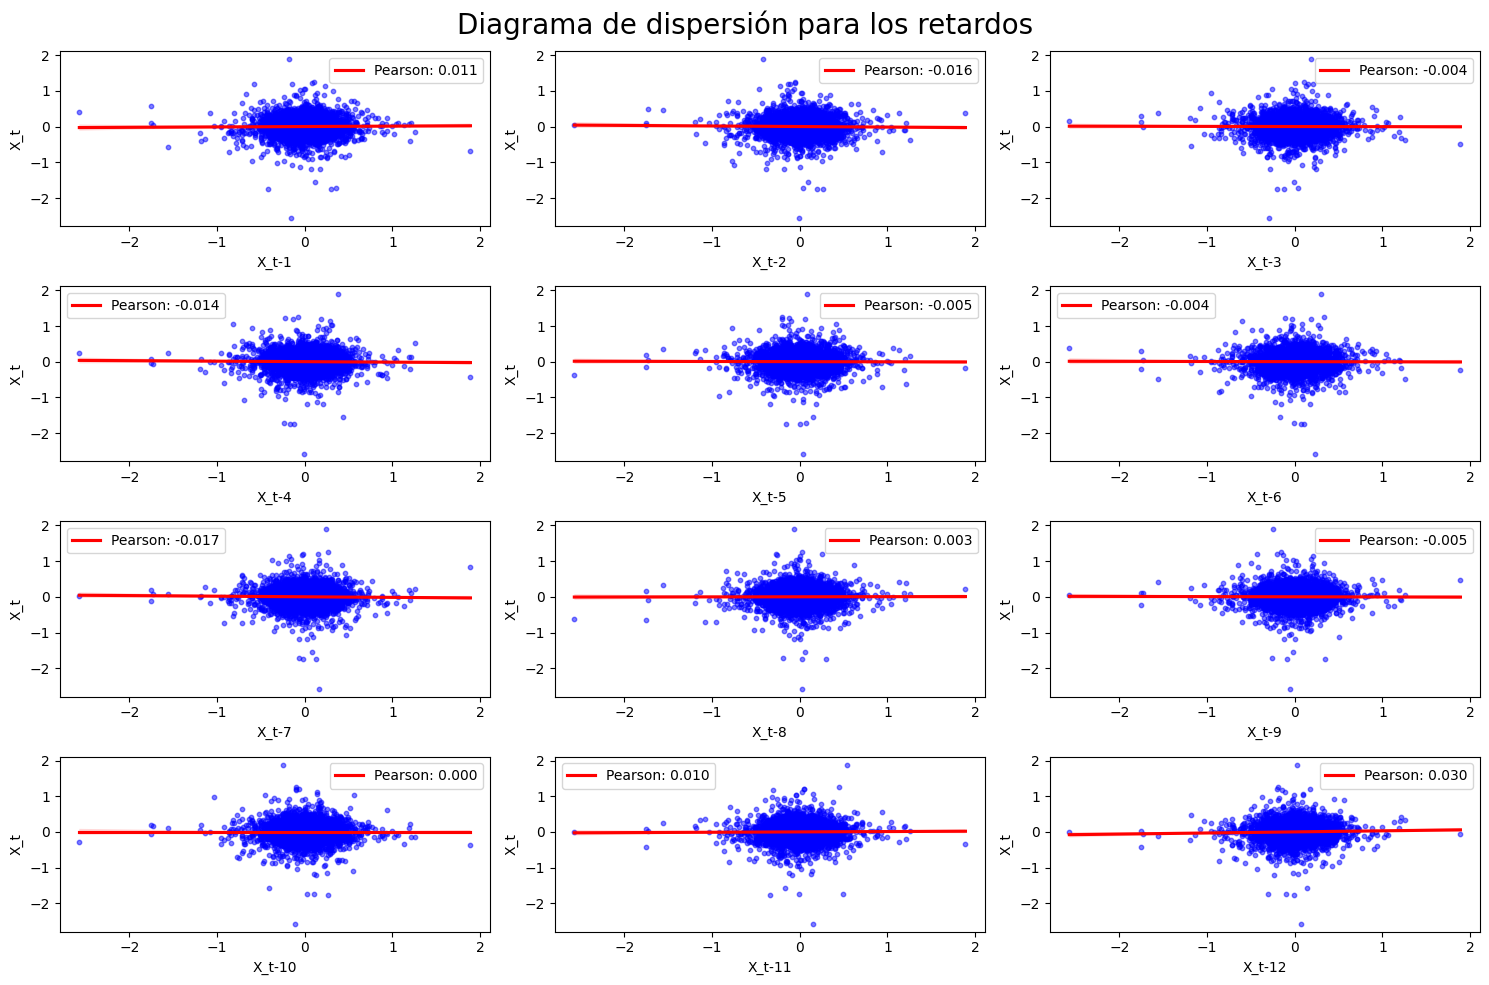

In [15]:
import seaborn as sns
from pandas.plotting import lag_plot

X_t = df['Close_diff']

# Crear un DataFrame con la serie temporal y sus lags
lags = range(1, 13)
for lag in lags:
    df[f'X_t-{lag}'] = X_t.shift(lag)

# Crear la matriz de plots
fig7, axes = plt.subplots(4, 3, figsize=(15, 10))
fig7.suptitle('Diagrama de dispersión para los retardos', fontsize=20)
for i in range(4):
    for j in range(3):
        lag = lags[3*i + j]
        # Crear el lag plot
        lag_plot(X_t, lag=lag, c='blue', alpha=0.5, marker='o', s=10, ax=axes[i, j], label=None)

        # Calcular el coeficiente de Pearson
        pearson_corr = df[f'X_t-{lag}'].corr(X_t)

        # Crear la línea de regresión
        sns.regplot(x=f'X_t-{lag}', y='Close_diff', data=df, scatter=False, color='red', ax=axes[i, j], label=f'Pearson: {pearson_corr:.3f}')

        axes[i, j].set_ylabel('X_t', fontsize=10)
        axes[i, j].set_xlabel(f'X_t-{lag}', fontsize=10)
        axes[i, j].legend()

# Ajustar el diseño de la matriz
plt.tight_layout()

# Guardar la imagen
plt.savefig('./img/lag_plot.jpg')

# Mostrar la imagen si es necesario
plt.show()


In [16]:
from PIL import Image
pil_image = Image.open("./img/lag_plot.jpg")

## 2.8 Indice AMI

Ahora utilizaremos los paquetes nonlinearTseries y tseriesChaos para computar el average mutual information(AMI) o La información mutua promedio (AMI, la cual mide cuánto nos dice una variable aleatoria sobre otra, el cual se define como:

$$I(X;Y)=\sum_{i}\sum_{j}p(x_i,y_j)\log_2(\frac{p(x_i,y_j)}{p(x_i)p(y_j)}).$$

En el contexto del análisis de series de tiempo, AMI ayuda a cuantificar la cantidad de conocimiento obtenido sobre el valor de $X_{t+d}$ al observar $X_t$. Equivalentemente, el AMI es una medida de qué tanto el conocimiento de $X$ reduce la incertidumbre acerca de $Y$. Esto implica que $I(X,Y)=0$ si y sólo si $X$ y $Y$ son variables aletorias independientes. I(X; Y ) describe la información que la medición $X_t$ en el tiempo $t$ aporta a la medición $X_{t+d}$ en el tiempo $t + d$. Si se elige d como el valor alrededor del primer mínimo del AMI, entonces $Y{t}$ e $y_{t+d}$ son parcialmente pero no totalmente independientes.

Vamos a simular una serie de la forma $$x_t=\frac{x_{t-1}}{x_{t-12}^2+1}+\epsilon_t$$ y a trabajar con la serie de linces Candienses del paquete astsa lynx.

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.feature_selection import mutual_info_regression

# Supongamos que tienes un DataFrame llamado df con una columna 'Close_diff'
# Reemplaza 'Close_diff' con el nombre real de tu columna
# Asegúrate de que los valores en la columna 'Close_diff' no contengan NaN

# Calcular los retardos (lags) de la serie temporal
lags = range(1, 13)

# Crear un DataFrame con la serie temporal y sus lags
df_lagged = pd.DataFrame({'Close_diff': df['Close_diff']})
for lag in lags:
    df_lagged[f'Close_diff_lag{lag}'] = df['Close_diff'].shift(lag)

# Eliminar filas con valores NaN resultantes de los retardos
df_lagged_cleaned = df_lagged.dropna()

# Seleccionar las columnas de los retardos para calcular la información mutua
selected_columns = [col for col in df_lagged_cleaned.columns if col != 'Close_diff']

# Calcular la información mutua para cada retardo
mi_values = []
for lag_column in selected_columns:
    mi = mutual_info_regression(df_lagged_cleaned[[lag_column]], df_lagged_cleaned['Close_diff'])
    mi_values.append(mi[0])

# Crear un DataFrame para la visualización
mi_df = pd.DataFrame({'Lag': lags, 'Average MI': mi_values})

# Graficar con Plotly
fig = px.line(mi_df, x='Lag', y='Average MI', title='Average Mutual Information for Different Lags',
              labels={'Average MI': 'Average Mutual Information', 'Lag': 'Lag'})
fig.show()


In [6]:

import seaborn as sns
import calendar
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
import calendar
from plotly.subplots import make_subplots
import warnings
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import UnivariateSpline
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import STL
import yfinance as yf
import matplotlib.pyplot as plt
import base64
from PIL import Image

# Importar datos
ticker_name = 'BC'
data = yf.download(ticker_name, start='2000-01-01', end='2020-01-01')
df = pd.DataFrame()
df["Date"] = data.index
df["Close"] = data["Close"].values

# Análisis Box-Cox
df['BoxCox_Close'], lambda_value = boxcox(df['Close'])
frac = 0.075
smoothed_values = lowess(df['BoxCox_Close'], df.index, frac=frac, it=0)
trend_removed = df['BoxCox_Close'] - smoothed_values[:, 1]

df['Trend_Removed'] = trend_removed

# Crear el box plot utilizando seaborn
import calendar
import plotly.express as px

# Crear una nueva columna para el nombre del mes
df['Month_Name'] = df['Date'].dt.month_name()

# Crear el box plot utilizando plotly.express
fig1 = px.box(df, x='Month_Name', y='Trend_Removed', title='Box Plot de trend_removed por Mes', labels={'Trend_Removed': 'Trend Removed'})
fig1.update_layout(title_text='Box Plot por Mes', title_x=0.5)
fig1.show()


[*********************100%***********************]  1 of 1 completed


In [19]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
from scipy.stats import gaussian_kde


# Extraer mes y año
df['Month'] = df['Date'].dt.strftime('%B')  # Obtener el nombre del mes

# Crear subplots para cada mes
fig2 = sp.make_subplots(rows=1, cols=len(df['Month'].unique()), shared_yaxes=True, subplot_titles=[f'{month}' for month in df['Month'].unique()])

# Calcular el KDE y las medias para cada mes
for i, month in enumerate(df['Month'].unique()):
    month_data = df[df['Month'] == month]['Trend_Removed']
    kde = gaussian_kde(month_data)
    x_vals = np.linspace(month_data.min(), month_data.max(), 1000)
    y_vals = kde(x_vals)

    # Añadir líneas de KDE para cada mes
    fig2.add_trace(go.Scatter(x=y_vals, y=x_vals, mode='lines', name=f'{month} KDE'), row=1, col=i+1)

    # Calcular y añadir la línea de la media
    month_mean = month_data.mean()
    fig2.add_trace(go.Scatter(x=[x_vals.min(), x_vals.max()], y=[month_mean, month_mean], mode='lines', name=f'{month} Media', line=dict(color='red', dash='dash')), row=1, col=i+1)

# Config2urar diseño
fig2.update_layout(title_text='KDE y Líneas de Media por Mes', yaxis_title='Trend Removed', showlegend=False)

# Mostrar gráfico
fig2.show()

[*********************100%***********************]  1 of 1 completed
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97030D-01    |proj g|=  4.06021D-01

At iterate    5    f=  1.55321D-01    |proj g|=  1.62133D-01

At iterate   10    f=  5.51055D-02    |proj g|=  2.06443D-01

At iterate   15    f=  2.04008D-02    |proj g|=  1.20956D-01

At iterate   20    f=  1.82498D-02    |proj g|=  3.27006D-03

At iterate   25    f=  1.82267D-02    |proj g|=  1.33312D-02

At iterate   30    f=  1.76563D-02    |proj g|=  1.79632D-02

At iterate   35    f=  1.71886D-02    |proj g|=  1.35156D-02

At iterate   40    f=  1.70759D-02    |proj g|=  1.64501D-03

At iterate   45    f=  1.70636D-02    |proj g|=  4.50639D-04


/home/plealm/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.70630D-02    |proj g|=  8.80758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   8.808D-04   1.706D-02
  F =   1.7062970165481629E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


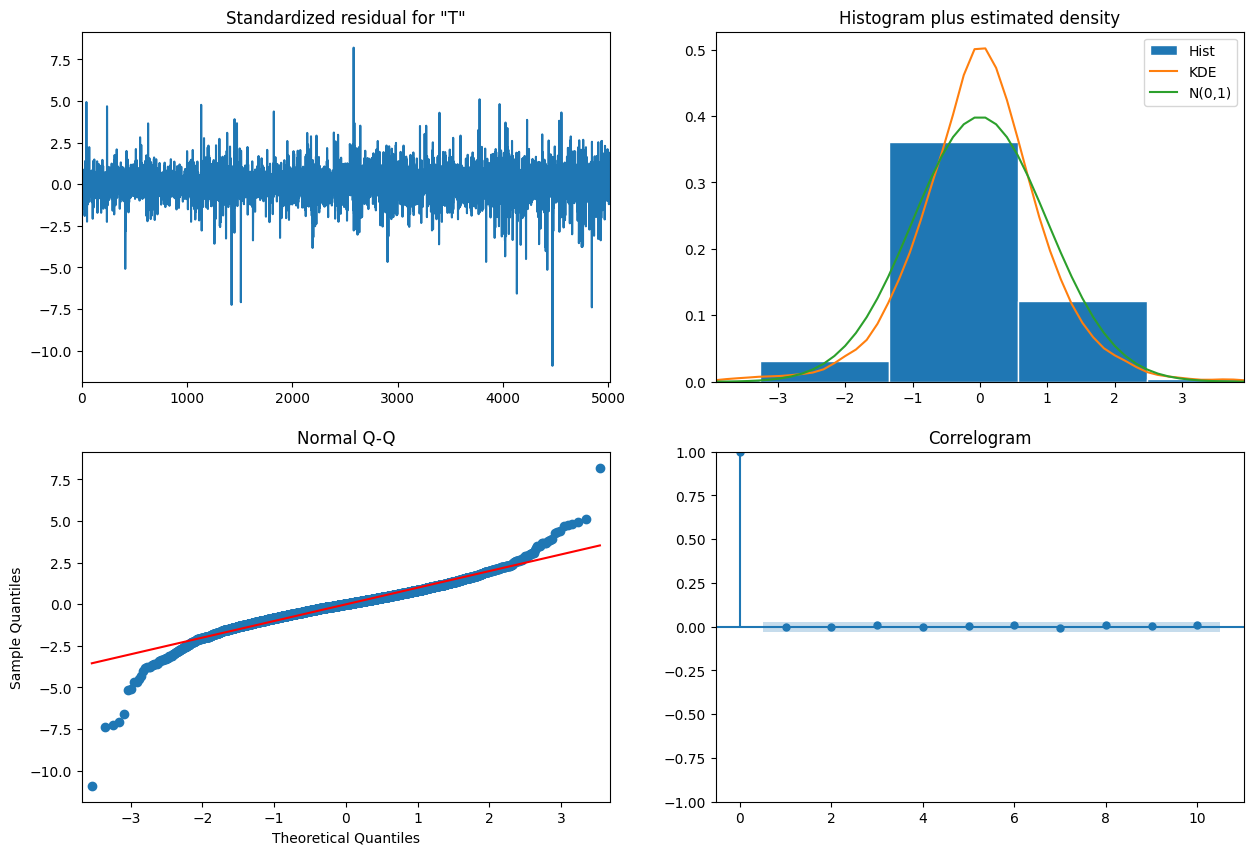

In [33]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import boxcox
from statsmodels.nonparametric.smoothers_lowess import lowess
import yfinance as yf

# Descargar datos
ticker_name = 'BC'
data = yf.download(ticker_name, start='2000-01-01', end='2020-01-01')

# Crear DataFrame
df = pd.DataFrame()
df["Date"] = data.index
df["Close"] = data["Close"].values

# Análisis Box-Cox
df['BoxCox_Close'], lambda_value = boxcox(df['Close'])
frac = 0.075
smoothed_values = lowess(df['BoxCox_Close'], df.index, frac=frac, it=0)
df['Trend_Removed'] = df['BoxCox_Close'] - smoothed_values[:, 1]

# Ajustar el modelo SARIMA
model = sm.tsa.statespace.SARIMAX(df['Trend_Removed'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Obtener las predicciones y ajustar al conjunto de datos original
df['Fitted'] = results.fittedvalues

# Gráfico de las observaciones originales y las predicciones ajustadas
results.plot_diagnostics(figsize=(15, 10))
plt.show()
